In [25]:
!pip install pymorphy2
!pip install emoji
!pip install transformers datasets torch sklearn iterative-stratification


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [26]:
import pandas as pd
import re
import pymorphy2
from tqdm import tqdm
import os
import emoji

# Инициализация морфологического анализатора
try:
    morph = pymorphy2.MorphAnalyzer()
    # Тест работы анализатора
    test_verb = morph.parse('решили')[0]
    if not any(tag in test_verb.tag for tag in ['INFN', 'VERB']):
        raise RuntimeError("Анализатор не определяет глаголы правильно")
except Exception as e:
    print(f"Ошибка инициализации pymorphy2: {e}")
    morph = None

# Словарь замены эмодзи (без нижних подчеркиваний)
EMOJI_MAP = {
    "😀": "улыбка", "😁": "радость", "😂": "смех", "🤣": "хохот",
    "😃": "радость", "😄": "счастье", "😅": "облегчение",
    "😆": "веселье", "😉": "подмигивание", "😊": "удовольствие",
    "😋": "вкуснятина", "😎": "круто", "😍": "обожание",
    "😘": "воздушный поцелуй", "😗": "поцелуй", "😙": "нежный поцелуй",
    "😚": "целование", "🤗": "объятия", "🤩": "восторг",
    "🤔": "задумчивость", "🤨": "подозрение", "😐": "нейтрально",
    "😑": "безэмоционально", "😶": "молчание", "😏": "ухмылка",
    "😣": "страдание", "😥": "разочарование", "😮": "удивление",
    "🤐": "молчок", "😯": "изумление", "😪": "сонливость",
    "😫": "усталость", "😴": "сон", "😌": "облегчение",
    "😛": "дразнилка", "😜": "шутка", "😝": "прикол",
    "🤤": "слюнки", "😒": "недовольство", "😓": "пот со лба",
    "😔": "грусть", "😕": "непонимание", "🙃": "наизнанку",
    "🤑": "жадность", "😲": "шок", "🙄": "закатывание глаз",
    "😷": "маска", "🤒": "температура", "🤕": "травма",
    "🤢": "тошнота", "🤮": "рвота", "🤧": "чихание",
    "😵": "головокружение", "🤯": "взрыв мозга", "😠": "злость",
    "😡": "ярость", "🤬": "ругань", "😈": "добрый дьявол",
    "👿": "злой дьявол", "👹": "огр", "👺": "гоблин",
    "💀": "череп", "👻": "привидение", "👽": "инопланетянин",
    "🤖": "робот", "😺": "кот радость", "😸": "кот счастье",
    "😹": "кот слезы радости", "😻": "кот обожание",
    "😼": "кот ухмылка", "😽": "кот поцелуй", "🙀": "кот шок",
    "😿": "кот грусть", "😾": "кот злость", "👶": "младенец",
    "🧒": "ребенок", "👦": "мальчик", "👧": "девочка",
    "👨": "мужчина", "👩": "женщина", "👴": "дедушка",
    "👵": "бабушка", "👮": "полицейский", "👷": "строитель",
    "💂": "гвардеец", "🕵️": "детектив", "👩‍⚕️": "врач",
    "👨‍⚕️": "доктор", "👩‍🌾": "фермер",
    "👨‍🌾": "фермер мужчина", "👩‍🍳": "повар", "👨‍🍳": "повар мужчина",
    "👩‍🎓": "студентка", "👨‍🎓": "студент", "👩‍🎤": "певица",
    "👨‍🎤": "певец", "👩‍🏫": "учительница",
    "👨‍🏫": "учитель", "👩‍🏭": "рабочая", "👨‍🏭": "рабочий",
    "👩‍💻": "программистка", "👨‍💻": "программист",
    "👩‍💼": "офисная работница", "👨‍💼": "офисный работник",
    "👩‍🔧": "механик", "👨‍🔧": "механик мужчина",
    "👩‍🔬": "ученая", "👨‍🔬": "ученый", "👩‍🎨": "художница",
    "👨‍🎨": "художник", "👩‍🚒": "пожарная", "👨‍🚒": "пожарный",
    "👩‍✈️": "пилот", "👨‍✈️": "пилот мужчина",
    "👩‍🚀": "астронавт", "👨‍🚀": "астронавт мужчина",
    "👩‍⚖️": "судья", "👨‍⚖️": "судья мужчина", "👰": "невеста",
    "🤵": "жених",
    "👸": "принцесса", "🤴": "принц", "🤶": "миссис клаус",
    "🎅": "санта", "🧙‍♀️": "волшебница", "🧙‍♂️": "волшебник",
    "🧝‍♀️": "эльфийка", "🧝‍♂️": "эльф",
    "🧛‍♀️": "вампирша", "🧛‍♂️": "вампир", "🧟‍♀️": "зомби",
    "🧟‍♂️": "зомби мужчина", "🧞‍♀️": "джинния", "🧞‍♂️": "джинн",
    "🧜‍♀️": "русалка", "🧜‍♂️": "тритон",
    "🧚‍♀️": "фея", "🧚‍♂️": "фея мужчина", "👼": "ангелочек",
    "🤰": "беременная", "🤱": "кормление грудью",
    "🙇‍♀️": "поклон женщина", "🙇‍♂️": "поклон мужчина",
    "💁‍♀️": "информация женщина", "💁‍♂️": "информация мужчина",
    "🙅‍♀️": "нет женщина", "🙅‍♂️": "нет мужчина",
    "🙆‍♀️": "да женщина", "🙆‍♂️": "да мужчина",
    "🙋‍♀️": "поднятие руки женщина",
    "🙋‍♂️": "поднятие руки мужчина",
    "🤦‍♀️": "лицо ладонь женщина", "🤦‍♂️": "лицо ладонь мужчина",
    "🤷‍♀️": "пожимание плечами женщина",
    "🤷‍♂️": "пожимание плечами мужчина", "🙎‍♀️": "надутые губы женщина",
    "🙎‍♂️": "надутые губы мужчина", "🙍‍♀️": "хмурость женщина",
    "🙍‍♂️": "хмурость мужчина", "💇‍♀️": "стрижка женщина",
    "💇‍♂️": "стрижка мужчина", "💆‍♀️": "массаж женщина",
    "💆‍♂️": "массаж мужчина", "🧖‍♀️": "сауна женщина",
    "🧖‍♂️": "сауна мужчина", "💅": "маникюр", "🤳": "селфи",
    "💃": "танцы женщина", "🕺": "танцы мужчина",
    "👯‍♀️": "девушки с кроличьими ушками",
    "👯‍♂️": "парни с кроличьими ушками",
    "🕴️": "левитирующий бизнесмен", "👫": "мужчина и женщина",
    "👬": "два мужчины", "👭": "две женщины", "💏": "поцелуй",
    "💑": "пара с сердцем", "👪": "семья",
    "🗣️": "говорящая голова", "👤": "силуэт", "👥": "силуэты",
    "🫂": "объятия", "👣": "следы", "🧳": "багаж",
    "🌂": "закрытый зонт", "☂️": "зонт", "🧵": "нитка",
    "🧶": "пряжа", "👓": "очки", "🕶️": "солнцезащитные очки",
    "🥽": "ласты", "🥼": "лабораторный халат",
    "🦺": "спасательный жилет", "👔": "галстук",
    "👕": "футболка", "👖": "джинсы", "🧣": "шарф",
    "🧤": "перчатки", "🧥": "пальто", "🧦": "носки",
    "👗": "платье", "👘": "кимоно", "🥻": "сари",
    "🩱": "купальник", "🩲": "трусы", "🩳": "шорты",
    "👙": "бикини", "👚": "женская одежда", "👛": "кошелек",
    "👜": "сумочка", "👝": "кошель", "🛍️": "пакеты",
    "🎒": "рюкзак", "🩴": "вьетнамки", "👞": "мужская обувь",
    "👟": "кроссовки", "🥾": "ботинки", "🥿": "балетки",
    "👠": "туфли на каблуке", "👡": "женские сандалии",
    "🩰": "балетные туфли", "👢": "женские сапоги",
    "👑": "корона", "👒": "женская шляпа", "🎩": "цилиндр",
    "🎓": "академическая шапочка", "🧢": "бейсболка",
    "🪖": "каска", "⛑️": "каска спасателя", "💄": "помада",
    "💍": "кольцо", "💼": "портфель",
        # Животные и природа (новые)
    "🐶": "собака", "🐱": "кот", "🐭": "мышь", "🐹": "хомяк",
    "🐰": "кролик", "🦊": "лиса", "🐻": "медведь", "🐼": "панда",
    "🐨": "коала", "🐯": "тигр", "🦁": "лев", "🐮": "корова",
    "🐷": "свинья", "🐸": "лягушка", "🐙": "осьминог", "🦄": "единорог",
    "🐝": "пчела", "🦋": "бабочка", "🐞": "божья коровка", "🦀": "краб",
    "🐬": "дельфин", "🦑": "кальмар", "🐘": "слон", "🦒": "жираф",
    "🐕": "собака", "🐈": "кот", "🦔": "еж", "🦇": "летучая мышь",
    "🌵": "кактус", "🎄": "елка", "🌹": "роза", "🌸": "цветок",
    "🌺": "гибискус", "🌻": "подсолнух", "🌼": "цветочек", "🍁": "кленовый лист",
    "🍂": "осенний лист", "🍃": "лист на ветру", "🌍": "земля", "🌞": "солнце",
    "🌚": "луна", "⭐": "звезда", "🌈": "радуга", "☀️": "солнце",
    "🌙": "луна", "⚡": "молния", "❄️": "снежинка", "☃️": "снеговик",

    # Еда и напитки (новые)
    "🍎": "яблоко", "🍐": "груша", "🍊": "апельсин", "🍋": "лимон",
    "🍌": "банан", "🍉": "арбуз", "🍇": "виноград", "🍓": "клубника",
    "🍒": "вишня", "🍑": "персик", "🍍": "ананас", "🥝": "киви",
    "🍅": "помидор", "🥑": "авокадо", "🍆": "баклажан", "🥔": "картошка",
    "🥕": "морковь", "🌽": "кукуруза", "🌶️": "перец", "🥐": "круассан",
    "🍞": "хлеб", "🥨": "крендель", "🧀": "сыр", "🍗": "курица",
    "🥩": "мясо", "🥓": "бекон", "🍔": "гамбургер", "🍟": "картошка фри",
    "🍕": "пицца", "🌮": "тако", "🍣": "суши", "🍩": "пончик",
    "🍪": "печенье", "🎂": "торт", "🍫": "шоколад", "🍿": "попкорн",
    "☕": "кофе", "🍵": "чай", "🍺": "пиво", "🍷": "вино",

    # Деятельность и спорт (новые)
    "⚽": "футбол", "🏀": "баскетбол", "🏈": "американский футбол",
    "⚾": "бейсбол", "🎾": "теннис", "🏐": "волейбол", "🎱": "бильярд",
    "🏓": "пинг понг", "🏸": "бадминтон", "🥊": "бокс", "⛸️": "коньки",
    "🎿": "лыжи", "⛷️": "лыжник", "🏂": "сноуборд", "🚴": "велосипед",
    "🏊": "плавание", "🤸": "колесо", "🧘": "медитация", "🎯": "дартс",
    "🎮": "видеоигры", "🎲": "кости", "♟️": "шахматы", "🎸": "гитара",
    "🎹": "пианино", "🎷": "саксофон", "🎺": "труба", "🎻": "скрипка",

    # Путешествия и транспорт (новые)
    "🚗": "машина", "🚕": "такси", "🚙": "внедорожник", "🚌": "автобус",
    "🚎": "троллейбус", "🚓": "полиция", "🚑": "скорая", "🚒": "пожарная",
    "🚜": "трактор", "🚲": "велосипед", "🛵": "мопед", "✈️": "самолет",
    "🚀": "ракета", "🛸": "летающая тарелка", "🚁": "вертолет", "⛵": "парусник",
    "🚤": "катер", "🛳️": "круизный лайнер", "🚂": "поезд", "🚊": "трамвай",
    "🚞": "горный поезд", "🚟": "подвесная дорога", "🚠": "канатная дорога",
    "🚡": "воздушный трамвай", "🚢": "корабль", "🛶": "каноэ", "🏍️": "мотоцикл",

    # Предметы и символы (новые)
    "💡": "лампочка", "🔦": "фонарик", "📱": "телефон", "💻": "ноутбук",
    "⌚": "часы", "📷": "фотоаппарат", "🎥": "кинокамера", "📺": "телевизор",
    "🔔": "колокольчик", "🎁": "подарок", "🎈": "шарик", "🎀": "ленточка",
    "👑": "корона", "🧸": "плюшевый мишка", "🛏️": "кровать", "🛋️": "диван",
    "🚿": "душ", "🛁": "ванна", "🚽": "унитаз", "🧻": "туалетная бумага",
    "🧴": "лосьон", "🧹": "метла", "🧺": "корзина", "🧯": "огнетушитель",

    # Флаги и страны (примеры)
    "🇷🇺": "Россия", "🇺🇸": "США", "🇬🇧": "Великобритания",
    "🇩🇪": "Германия", "🇫🇷": "Франция", "🇨🇳": "Китай",
    "🇯🇵": "Япония", "🇰🇷": "Корея", "🇮🇹": "Италия",
    "🇪🇸": "Испания", "🏳️": "белый флаг", "🏴": "черный флаг",

    # Специальные символы
    "❤️": "сердце", "💔": "разбитое сердце", "💘": "сердце со стрелой",
    "💝": "сердце с лентой", "💖": "блестящее сердце", "💗": "растущее сердце",
    "💓": "бьющееся сердце", "💞": "вращающиеся сердца", "💕": "два сердца",
    "💟": "украшение в виде сердца", "❣️": "восклицание сердце", "💌": "любовное письмо",
    "💬": "баббл речи", "🗨️": "левый баббл речи", "🗯️": "правый баббл гнева",
    "💭": "баббл мысли", "💤": "zzz", "🛑": "стоп", "⛔": "въезд запрещен",
    "🚫": "запрещено", "💯": "сотка", "🔞": "18+", "📛": "предупреждение",

    # Руки и жесты
    "🤲": "ладони вверх", "👐": "раскрытые ладони", "🙌": "поднятые руки",
    "👏": "аплодисменты", "🤝": "рукопожатие", "👍": "палец вверх",
    "👎": "палец вниз", "✊": "кулак", "👊": "удар кулаком",
    "🤛": "кулак влево", "🤜": "кулак вправо", "🤞": "скрещенные пальцы",
    "✌️": "победа", "🤟": "жест любви", "🤘": "рожки", "👌": "окей",
    "🤏": "щепотка", "🤙": "позвони мне", "👈": "палец влево",
    "👉": "палец вправо", "👆": "палец вверх", "👇": "палец вниз",
    "✋": "рука стоп", "🤚": "поднятая рука", "🖐️": "растопыренные пальцы",
    "🖖": "вулканский салют", "👋": "махание рукой", "🤙": "позвони мне",

    # Профессии
    "👨‍⚕️": "доктор мужчина", "👩‍⚕️": "доктор женщина",
    "👨‍🎓": "студент мужчина", "👩‍🎓": "студент женщина",
    "👨‍🏫": "учитель мужчина", "👩‍🏫": "учитель женщина",
    "👨‍⚖️": "судья мужчина", "👩‍⚖️": "судья женщина",
    "👨‍🌾": "фермер мужчина", "👩‍🌾": "фермер женщина",
    "👨‍🍳": "повар мужчина", "👩‍🍳": "повар женщина",
    "👨‍🔧": "механик мужчина", "👩‍🔧": "механик женщина",
    "👨‍🏭": "рабочий мужчина", "👩‍🏭": "рабочий женщина",
    "👨‍💼": "офисный работник мужчина", "👩‍💼": "офисный работник женщина",
    "👨‍🔬": "ученый мужчина", "👩‍🔬": "ученый женщина",
    "👨‍💻": "программист мужчина", "👩‍💻": "программист женщина",
    "👨‍🎤": "певец", "👩‍🎤": "певица", "👨‍🎨": "художник мужчина",
    "👩‍🎨": "художник женщина", "👨‍✈️": "пилот мужчина", "👩‍✈️": "пилот женщина",
    "👨‍🚀": "астронавт мужчина", "👩‍🚀": "астронавт женщина",
    "👨‍🚒": "пожарный мужчина", "👩‍🚒": "пожарный женщина",
    "👮‍♂️": "полицейский мужчина", "👮‍♀️": "полицейский женщина",
    "🕵️‍♂️": "детектив мужчина", "🕵️‍♀️": "детектив женщина",
    "💂‍♂️": "гвардеец мужчина", "💂‍♀️": "гвардеец женщина",
    "👷‍♂️": "строитель мужчина", "👷‍♀️": "строитель женщина",

    # Праздники и события
    "🎃": "хэллоуин", "🎄": "рождество", "🎆": "фейерверк",
    "🎇": "бенгальский огонь", "🧨": "петарда", "✨": "блестки",
    "🎉": "празднование", "🎊": "конфетти", "🎎": "японские куклы",
    "🎏": "карповые флаги", "🎐": "колокольчик ветра", "🎑": "праздник луны",
    "🧧": "красный конверт", "🎀": "ленточка", "🎁": "подарок",
    "🎫": "билет", "🏆": "трофей", "🏅": "медаль", "🥇": "золотая медаль",
    "🥈": "серебряная медаль", "🥉": "бронзовая медаль", "⚽": "футбольный мяч",
    "🏀": "баскетбольный мяч", "🏈": "мяч для американского футбола",
    "⚾": "бейсбольный мяч", "🎾": "теннисный мяч", "🏐": "волейбольный мяч",
    "🎱": "бильярдный шар", "🏓": "пинг понг", "🏸": "волан",
    "🥅": "ворота", "⛳": "флаг в лунке", "🎣": "удочка", "🎽": "майка",
    "🛷": "санки", "🥌": "керлинг", "🎯": "дартс", "🪀": "йо йо",
    "🪁": "воздушный змей", "🔮": "хрустальный шар", "🎮": "геймпад",
    "🎲": "игральные кости", "♟️": "шахматная пешка", "🎭": "театр",
    "🎨": "художник", "🧵": "нить", "🪡": "игла", "🧶": "пряжа",
    "🛒": "тележка", "🛍️": "пакеты", "🎎": "японские куклы",
    "🎏": "кои нобори", "🎐": "фурин", "🎀": "лента",

    # Техника и инструменты
    "📱": "смартфон", "📲": "смартфон со стрелкой", "💻": "ноутбук",
    "⌨️": "клавиатура", "🖥️": "компьютер", "🖨️": "принтер",
    "🖱️": "мышка", "🖲️": "трекбол", "💽": "дискета", "💾": "диск",
    "💿": "оптический диск", "📀": "dvd", "📼": "кассета", "📷": "фотоаппарат",
    "🎥": "видеокамера", "📹": "камера", "📺": "телевизор", "📻": "радио",
    "🎙️": "микрофон", "🎚️": "ползунок", "🎛️": "кнопки управления",
    "🧭": "компас", "⏱️": "секундомер", "⏲️": "таймер", "⏰": "будильник",
    "🕰️": "часы с маятником", "⌛": "песочные часы", "⏳": "песочные часы с песком",
    "📡": "спутниковая антенна", "🔋": "батарейка", "🔌": "вилка",
    "💡": "лампочка", "🔦": "фонарик", "🕯️": "свеча", "🧯": "огнетушитель",
    "🛢️": "бочка", "💸": "деньги с крыльями", "💵": "доллары",
    "💴": "йены", "💶": "евро", "💷": "фунты", "🧾": "чек",
    "💳": "кредитная карта", "💹": "график роста", "✉️": "конверт",
    "📧": "email", "📨": "входящее письмо", "📩": "письмо со стрелкой",
    "📤": "исходящие", "📥": "входящие", "📦": "посылка", "📫": "почтовый ящик",
    "📪": "почтовый ящик с флажком", "📬": "открытый почтовый ящик",
    "📭": "почтовый ящик без флажка", "📮": "почтовый ящик", "🗳️": "урна для голосования",
    "✏️": "карандаш", "✒️": "перо", "🖋️": "перьевая ручка", "🖊️": "ручка",
    "🖌️": "кисть", "🖍️": "мелок", "📝": "заметка", "📁": "папка",
    "📂": "открытая папка", "🗂️": "разделители", "📅": "календарь",
    "📆": "отрывной календарь", "🗒️": "блокнот", "🗓️": "календарь блокнот",
    "📇": "карточка", "📈": "график роста", "📉": "график падения",
    "📊": "гистограмма", "📋": "буфер обмена", "📌": "кнопка",
    "📍": "кнопка место", "📎": "скрепка", "🖇️": "соединенные скрепки",
    "📏": "линейка", "📐": "треугольник", "✂️": "ножницы", "🗃️": "картотека",
    "🗄️": "шкаф", "🗑️": "корзина", "🔒": "замок", "🔓": "открытый замок",
    "🔏": "замок с пером", "🔐": "замок с ключом", "🔑": "ключ",
    "🗝️": "старый ключ", "🔨": "молоток", "🪓": "топор", "⛏️": "кирка",
    "⚒️": "молоток и кирка", "🛠️": "молоток и гаечный ключ", "🗡️": "кинжал",
    "⚔️": "мечи", "🔫": "пистолет", "🪃": "бумеранг", "🏹": "лук и стрелы",
    "🛡️": "щит", "🪚": "пила", "🔧": "гаечный ключ", "🔩": "гайка и болт",
    "⚙️": "шестеренка", "🗜️": "тиски", "⚖️": "весы", "🦯": "трость",
    "🔗": "ссылка", "⛓️": "цепи", "🪝": "крюк", "🧰": "инструменты",
    "🧲": "магнит", "🪜": "лестница", "⚗️": "алхимический сосуд",
    "🧪": "пробирка", "🧫": "чашка петри", "🧬": "днк", "🔬": "микроскоп",
    "🔭": "телескоп", "📡": "спутниковая антенна", "💉": "шприц",
    "🩸": "капля крови", "💊": "таблетка", "🩹": "пластырь", "🩺": "стетоскоп",
    "🚪": "дверь", "🛏️": "кровать", "🛋️": "диван", "🪑": "стул",
    "🚽": "унитаз", "🚿": "душ", "🛁": "ванна", "🪒": "бритва",
    "🧴": "лосьон", "🧷": "булавка", "🧹": "метла", "🧺": "корзина",
    "🧻": "туалетная бумага", "🪣": "ведро", "🧼": "мыло", "🪥": "зубная щетка",
    "🧽": "губка", "🧯": "огнетушитель", "🛒": "тележка", "🚬": "сигарета",
    "⚰️": "гроб", "🪦": "надгробие", "⚱️": "урна", "🏺": "амфора",
    "🪔": "дипа", "🧿": "назар", "🪄": "волшебная палочка", "🧙": "волшебник",
    "🧚": "фея", "🧛": "вампир", "🧜": "русалка", "🧝": "эльф",
    "🧞": "джинн", "🧟": "зомби", "🧌": "тролль", "💌": "любовное письмо",
    "🕳️": "дыра", "💣": "бомба", "🛀": "человек в ванне", "🛌": "человек в кровати",
    "🧑‍🤝‍🧑": "люди держатся за руки", "👭": "две женщины", "👬": "два мужчины",
    "👫": "мужчина и женщина", "💏": "поцелуй", "💑": "пара с сердцем",
    "👪": "семья", "🗣️": "говорящая голова", "👤": "силуэт", "👥": "силуэты",
    "🫂": "объятия", "👣": "следы", "🧳": "багаж", "🌂": "закрытый зонт",
    "☂️": "зонт", "🧵": "нитка", "🧶": "пряжа", "👓": "очки",
    "🕶️": "солнцезащитные очки", "🥽": "ласты", "🥼": "лабораторный халат",
    "🦺": "спасательный жилет", "👔": "галстук", "👕": "футболка",
    "👖": "джинсы", "🧣": "шарф", "🧤": "перчатки", "🧥": "пальто",
    "🧦": "носки", "👗": "платье", "👘": "кимоно", "🥻": "сари",
    "🩱": "купальник", "🩲": "трусы", "🩳": "шорты", "👙": "бикини",
    "👚": "женская одежда", "👛": "кошелек", "👜": "сумочка", "👝": "кошель",
    "🛍️": "пакеты", "🎒": "рюкзак", "🩴": "вьетнамки", "👞": "мужская обувь",
    "👟": "кроссовки", "🥾": "ботинки", "🥿": "балетки", "👠": "туфли на каблуке",
    "👡": "женские сандалии", "🩰": "балетные туфли", "👢": "женские сапоги",
    "👑": "корона", "👒": "женская шляпа", "🎩": "цилиндр", "🎓": "академическая шапочка",
    "🧢": "бейсболка", "🪖": "каска", "⛑️": "каска спасателя", "💄": "помада",
    "💍": "кольцо", "💼": "портфель"
}

def replace_emojis(text):
    """Замена эмодзи на текстовые описания (без нижних подчеркиваний)"""
    if not isinstance(text, str):
        return text

    # Сначала заменяем известные эмодзи из нашего словаря
    for emoji_char, description in EMOJI_MAP.items():
        text = text.replace(emoji_char, f" {description} ")

    # Затем обрабатываем остальные эмодзи через emoji.demojize
    text = emoji.demojize(text, delimiters=(" ", " "))

    # Заменяем оставшиеся нижние подчеркивания на пробелы
    text = text.replace("_", " ")

    return text

def to_infinitive(text):
    """Приведение глаголов к инфинитиву"""
    if not morph or not isinstance(text, str):
        return text

    words = text.split()
    processed = []

    for word in words:
        # Пропускаем слова с цифрами и пунктуацией
        if not re.fullmatch(r'[а-яёА-ЯЁ-]+', word):
            processed.append(word)
            continue

        parsed = morph.parse(word)[0]

        # Для глаголов и причастий/деепричастий
        if any(tag in parsed.tag for tag in ['INFN', 'VERB', 'PRTF', 'GRND']):
            # Пытаемся поставить в инфинитив
            inf = parsed.inflect({'INFN'})
            if inf:
                processed.append(inf.word)
            else:
                processed.append(parsed.normal_form)
        else:
            processed.append(word)

    return ' '.join(processed)

def process_text(text):
    """Полная обработка текста"""
    if not isinstance(text, str):
        return ""

    # Замена эмодзи (первым этапом)
    text = replace_emojis(text)

    # Приведение к инфинитиву
    text = to_infinitive(text)

    # Очистка текста
    text = re.sub(r'[^\w\s-]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip().lower()

    return text

def process_comments(input_path, output_path):
    """Обработка файла с комментариями"""
    try:
        if not os.path.exists(input_path):
            raise FileNotFoundError(f"Файл {input_path} не найден")

        # Чтение файла с попыткой разных кодировок
        encodings = ['utf-8', 'windows-1251', 'cp1251']
        for enc in encodings:
            try:
                df = pd.read_csv(input_path, encoding=enc)
                break
            except UnicodeDecodeError:
                continue
        else:
            raise ValueError("Не удалось определить кодировку файла")

        if 'comment' not in df.columns:
            raise KeyError(f"Колонка 'comment' не найдена. Доступные колонки: {list(df.columns)}")

        print(f"Найдено {len(df)} комментариев для обработки")

        # Обработка с прогресс-баром
        tqdm.pandas(desc="Обработка")
        df['processed_comment'] = df['comment'].progress_apply(process_text)

        # Сохранение результатов
        df.to_csv(output_path, index=False, encoding='utf-8')

        # Вывод примеров
        print("\nПримеры обработки:")
        for i, row in df.head().iterrows():
            print(f"\nОригинал: {row['comment']}")
            print(f"Результат: {row['processed_comment']}")

        return True

    except Exception as e:
        print(f"\nОшибка: {str(e)}")
        return False

# Запуск обработки
if __name__ == "__main__":
    input_file = "/content/1var.csv"
    output_file = "/content/processed_comments.csv"

    if process_comments(input_file, output_file):
        print(f"\nРезультаты сохранены в {output_file}")
    else:
        print("\nОбработка завершена с ошибками...")


Ошибка инициализации pymorphy2: module 'inspect' has no attribute 'getargspec'
Найдено 1815 комментариев для обработки


Обработка: 100%|██████████| 1815/1815 [00:00<00:00, 5068.21it/s]


Примеры обработки:

Оригинал: Благодарю за оперативное решение проблемы !
Результат: благодарю за оперативное решение проблемы

Оригинал: спасибо управляющей компании за то что  прислали грамотного специалиста и быстро отреагировали на заявку
Результат: спасибо управляющей компании за то что прислали грамотного специалиста и быстро отреагировали на заявку

Оригинал: Решили мой вопрос. Спасибо!
Результат: решили мой вопрос спасибо

Оригинал: Все исправили
Результат: все исправили

Оригинал: спасибо большое! теперь не скрипят
Результат: спасибо большое теперь не скрипят

Результаты сохранены в /content/processed_comments.csv



Распределение для 'Вопрос решен':
Вопрос решен
0    1060
1     755
Name: count, dtype: int64


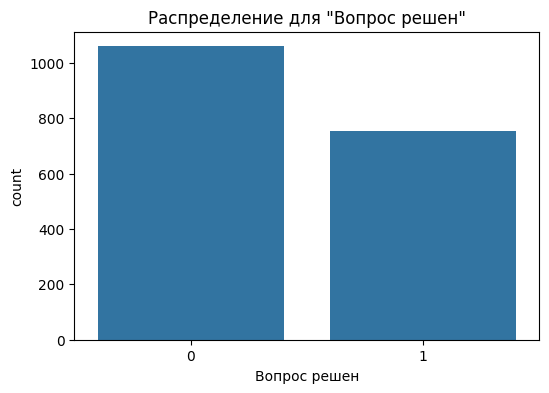


Распределение для 'Лишнее':
Лишнее
0    1550
1     265
Name: count, dtype: int64


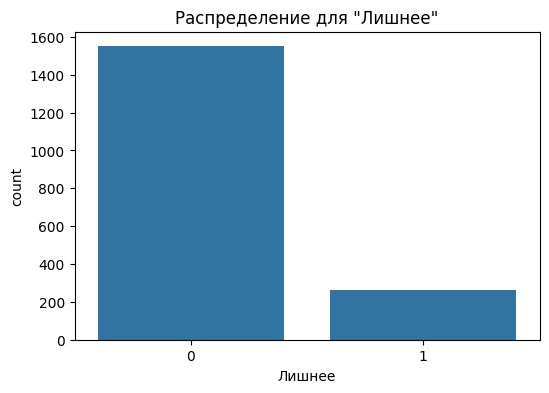


Распределение для 'Нравится качество выполнения заявки':
Нравится качество выполнения заявки
0    1605
1     210
Name: count, dtype: int64


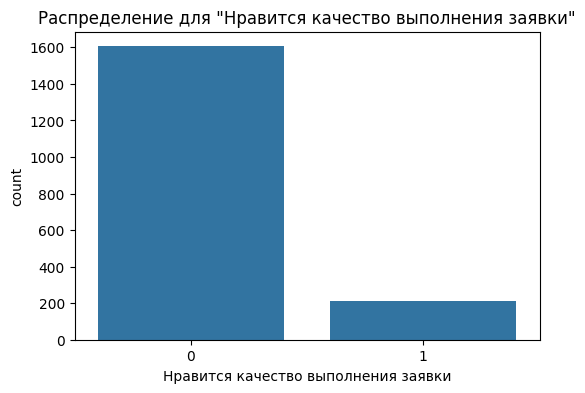


Распределение для 'Нравится качество работы сотрудников':
Нравится качество работы сотрудников
0    1455
1     360
Name: count, dtype: int64


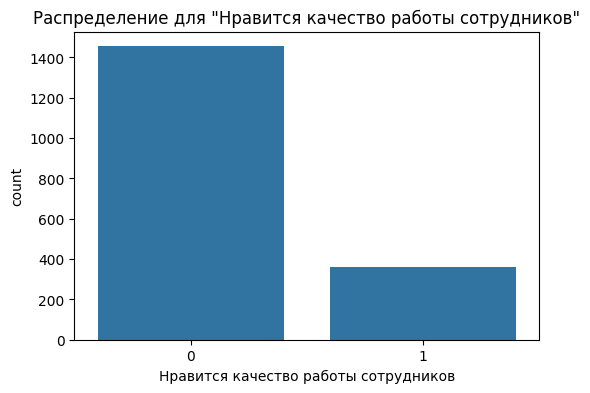


Распределение для 'Нравится скорость отработки заявок':
Нравится скорость отработки заявок
0    1111
1     704
Name: count, dtype: int64


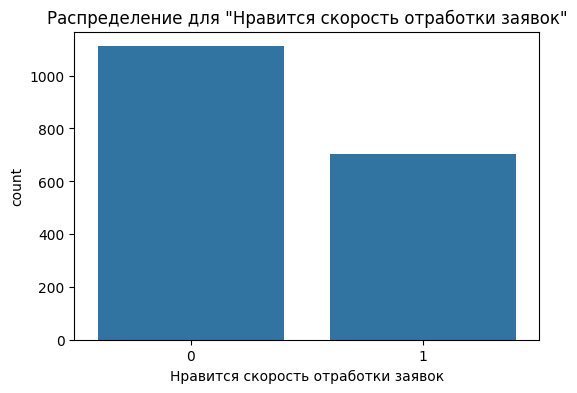


Распределение для 'Понравилось выполнение заявки':
Понравилось выполнение заявки
0    1338
1     477
Name: count, dtype: int64


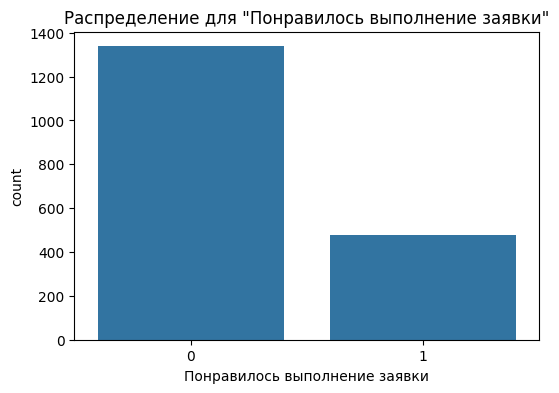

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
df = pd.read_csv("/content/processed_comments.csv")

# Определение целевых переменных (категорий)
target_columns = [
    'Вопрос решен',
    'Лишнее',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки'
]

# Анализ распределения классов
for col in target_columns:
    print(f"\nРаспределение для '{col}':")
    print(df[col].value_counts())
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col)
    plt.title(f'Распределение для "{col}"')
    plt.show()

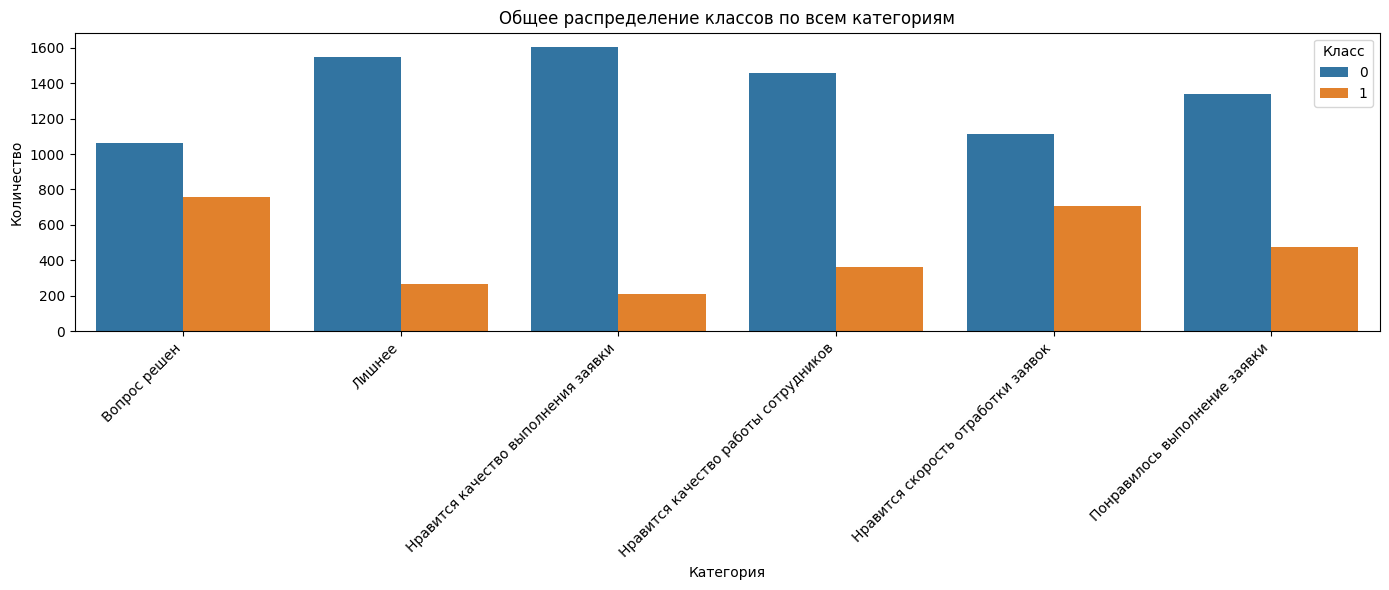

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
df = pd.read_csv("/content/processed_comments.csv")

# Целевые переменные
target_columns = [
    'Вопрос решен',
    'Лишнее',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки'
]

# Подготовка данных для общего графика
counts = []
for col in target_columns:
    value_counts = df[col].value_counts().to_dict()
    for val, count in value_counts.items():
        counts.append({'Категория': col, 'Значение': val, 'Количество': count})

# Преобразуем в DataFrame
plot_df = pd.DataFrame(counts)

# Построение общего графика
plt.figure(figsize=(14, 6))
sns.barplot(data=plot_df, x='Категория', y='Количество', hue='Значение')

plt.title('Общее распределение классов по всем категориям')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Класс')
plt.tight_layout()
plt.show()



In [29]:


# Если у тебя отдельные колонки по классам (0/1):
label_cols = ['Вопрос решен', 'Лишнее',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки']
texts = df['processed_comment'].tolist()
labels = df[label_cols].values  # numpy array с 0/1

# Или если labels в одной колонке строка-список, нужно преобразовать
# import ast
# df['labels'] = df['labels'].apply(ast.literal_eval)
# labels = df['labels'].tolist()


In [30]:
!pip install iterative-stratification


In [31]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np

X = np.array(texts)
y = labels

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Для примера возьмём первый разбиение
for train_index, val_index in mskf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    break


In [32]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np

# Пример данных (замените на свои реальные данные)
X = np.array(texts)
y = labels

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Первое разбиение
for train_index, val_index in mskf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    break

# Расчёт и вывод процентов
total_samples = len(X)
train_percent = len(X_train) / total_samples * 100
val_percent = len(X_val) / total_samples * 100

print(f"Train samples: {len(X_train)} ({train_percent:.2f}%)")
print(f"Validation samples: {len(X_val)} ({val_percent:.2f}%)")


Train samples: 1457 (80.28%)
Validation samples: 358 (19.72%)


In [33]:
import torch

# y_train — numpy array, shape (N, num_classes)

pos_weight = torch.tensor(
    [(y_train[:, i] == 0).sum() / (y_train[:, i] == 1).sum() for i in range(y_train.shape[1])],
    dtype=torch.float
)


In [34]:
!pip install --upgrade transformers

In [35]:
!pip install huggingface_hub[hf_xet]


In [36]:
df.head()

,Unnamed: 0,comment,id,rating,Вопрос решен,Лишнее,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки,processed_comment
0,0,Благодарю за оперативное решение проблемы !,3381812,5,1,0,0,0,1,0,благодарю за оперативное решение проблемы
1,1,спасибо управляющей компании за то что присла...,3627490,5,0,0,0,1,1,0,спасибо управляющей компании за то что прислал...
2,2,Решили мой вопрос. Спасибо!,3695420,5,1,0,0,0,0,1,решили мой вопрос спасибо
3,3,Все исправили,3726842,5,1,0,0,0,0,0,все исправили
4,4,спасибо большое! теперь не скрипят,3751364,5,0,0,1,0,0,1,спасибо большое теперь не скрипят


In [37]:
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx].astype(float)
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),  # (max_len)
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

train_dataset = MultiLabelDataset(X_train, y_train, tokenizer)
val_dataset = MultiLabelDataset(X_val, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=y_train.shape[1],
    problem_type="multi_label_classification"
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Рассчитаем pos_weight для BCEWithLogitsLoss
pos_weight = pos_weight.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = AdamW(model.parameters(), lr=2e-5)

# Простой цикл обучения на 1 эпоху

model.train()
for batch in train_loader:
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits

    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

print("Epoch done.")
# После окончания обучения (после цикла):

output_dir = "/content/checkpoint-1452"

# Сохраняем модель и токенизатор
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch done.
Model and tokenizer saved to /content/checkpoint-1452


In [38]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

test_model_path = '/content/checkpoint-1452'

tokenizer = AutoTokenizer.from_pretrained(test_model_path)
model = AutoModelForSequenceClassification.from_pretrained(test_model_path)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


comment_section = [
    'я люблю чай',
    'я хочу спать',
    'Алексей молодец!Все починил быстро и качесвтенно',
    'Недоволен выполнением работ, лучше бы не делали',
    'Качественнно и быстро, спасибо!',
    'спасибо !!!!:)))))))))'
]

for comment in comment_section:
    encoding = tokenizer(comment, return_tensors='pt', truncation=True, padding=True, max_length=128)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits)  # вероятность для каждого лейбла

    probs = probs.cpu().numpy()[0]
    print(f"Comment: {comment}")
    print("Probabilities per label:", probs)
    print()

print()

Comment: я люблю чай
Probabilities per label: [0.5023973  0.48963025 0.19162129 0.3998481  0.30145985 0.5137912 ]

Comment: я хочу спать
Probabilities per label: [0.5184079  0.46305776 0.19739448 0.41917613 0.3265647  0.5248746 ]

Comment: Алексей молодец!Все починил быстро и качесвтенно
Probabilities per label: [0.4622795  0.32005858 0.8344925  0.6083827  0.76698214 0.45213184]

Comment: Недоволен выполнением работ, лучше бы не делали
Probabilities per label: [0.38389626 0.86244684 0.39405513 0.52860945 0.35423958 0.44852036]

Comment: Качественнно и быстро, спасибо!
Probabilities per label: [0.4569541  0.32601216 0.8718625  0.5348965  0.781703   0.4774573 ]

Comment: спасибо !!!!:)))))))))
Probabilities per label: [0.51075834 0.3466637  0.29496342 0.4266808  0.37778488 0.5288364 ]




In [44]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Пусть это будут названия ваших меток
label_columns = [
    'Вопрос решен',
    'Лишнее',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки'
]

test_model_path = '/content/checkpoint-1452'

tokenizer = AutoTokenizer.from_pretrained(test_model_path)
model = AutoModelForSequenceClassification.from_pretrained(test_model_path)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

comment_section = [
    'я люблю чай',
    'я хочу спать',
    'Алексей молодец! Все починил быстро и качественно',
    'Недоволен выполнением работ, лучше бы не делали',
    'Качественно и быстро, спасибо!',
    'спасибо !!!!:)))))))))'
]

for comment in comment_section:
    encoding = tokenizer(comment, return_tensors='pt', truncation=True, padding=True, max_length=128)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits)  # вероятность для каждого лейбла

    probs = probs.cpu().numpy()[0]
    print(f"\nComment: {comment}")
    for label, prob in zip(label_columns, probs):
        if prob > 0.5:
            print(f"  - {label}: {prob:.3f}")



Comment: я люблю чай
  - Вопрос решен: 0.502
  - Понравилось выполнение заявки: 0.514

Comment: я хочу спать
  - Вопрос решен: 0.518
  - Понравилось выполнение заявки: 0.525

Comment: Алексей молодец! Все починил быстро и качественно
  - Нравится качество выполнения заявки: 0.857
  - Нравится качество работы сотрудников: 0.589
  - Нравится скорость отработки заявок: 0.776

Comment: Недоволен выполнением работ, лучше бы не делали
  - Лишнее: 0.862
  - Нравится качество работы сотрудников: 0.529

Comment: Качественно и быстро, спасибо!
  - Нравится качество выполнения заявки: 0.872
  - Нравится качество работы сотрудников: 0.526
  - Нравится скорость отработки заявок: 0.782

Comment: спасибо !!!!:)))))))))
  - Вопрос решен: 0.511
  - Понравилось выполнение заявки: 0.529


In [45]:
from sklearn.metrics import roc_auc_score

# preds — модельные предсказания вероятностей, shape = (num_samples, num_classes)
# targets — истинные метки (0 или 1), shape = (num_samples, num_classes)

model.eval()
all_targets = []
all_preds = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        probs = torch.sigmoid(logits)
        all_preds.append(probs.cpu().numpy())
        all_targets.append(labels.cpu().numpy())

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

roc_auc = roc_auc_score(all_targets, all_preds, average='macro')
print(f'Validation ROC-AUC: {roc_auc:.4f}')


Validation ROC-AUC: 0.7403


In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
label_columns = [
    'Вопрос решен',
    'Лишнее',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки'
]
# 1) Преобразуем вероятности в «жёсткие» метки (threshold = 0.5)
y_true = all_targets
y_pred = (all_preds >= 0.5).astype(int)

# 2) Считаем Precision, Recall и F1 (macro и micro)
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro    = recall_score   (y_true, y_pred, average='macro')
f1_macro        = f1_score       (y_true, y_pred, average='macro')

precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro    = recall_score   (y_true, y_pred, average='micro')
f1_micro        = f1_score       (y_true, y_pred, average='micro')

print(f"\nPrecision (macro): {precision_macro:.3f}")
print(f"Recall    (macro): {recall_macro:.3f}")
print(f"F1‑score  (macro): {f1_macro:.3f}\n")

print(f"Precision (micro): {precision_micro:.3f}")
print(f"Recall    (micro): {recall_micro:.3f}")
print(f"F1‑score  (micro): {f1_micro:.3f}\n")

# 3) Подробный отчёт по каждому классу
print("Classification Report по классам:")
print(classification_report(y_true, y_pred, target_names=label_columns))


Precision (macro): 0.430
Recall    (macro): 0.730
F1‑score  (macro): 0.526

Precision (micro): 0.431
Recall    (micro): 0.727
F1‑score  (micro): 0.542

Classification Report по классам:
                                      precision    recall  f1-score   support

                        Вопрос решен       0.46      0.67      0.54       151
                              Лишнее       0.44      0.89      0.59        53
 Нравится качество выполнения заявки       0.31      0.69      0.42        42
Нравится качество работы сотрудников       0.24      0.79      0.37        72
  Нравится скорость отработки заявок       0.75      0.91      0.82       141
       Понравилось выполнение заявки       0.37      0.43      0.40        95

                           micro avg       0.43      0.73      0.54       554
                           macro avg       0.43      0.73      0.53       554
                        weighted avg       0.48      0.73      0.56       554
                         sample

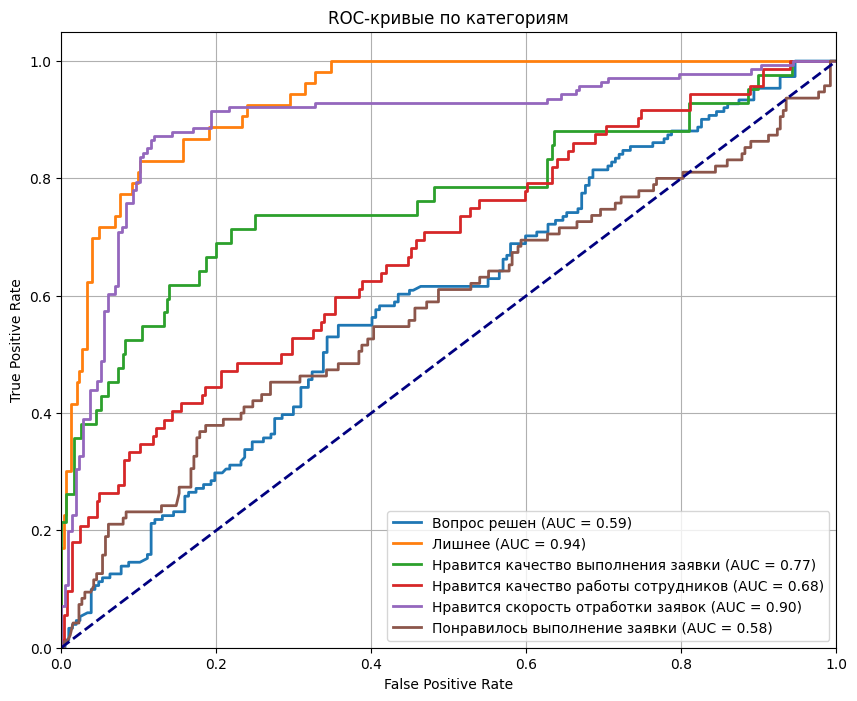

In [47]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import torch
label_columns = [
    'Вопрос решен',
    'Лишнее',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки'
]
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits)

        all_labels.append(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

labels = np.vstack(all_labels)
probs = np.vstack(all_probs)

# Строим ROC-кривые
plt.figure(figsize=(10, 8))
for i in range(len(label_columns)):
    fpr, tpr, _ = roc_curve(labels[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label_columns[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые по категориям')
plt.legend(loc='lower right')
plt.grid()
plt.show()
